In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import zlib, base64
from skimage.io import imread
import cv2 as cv
import os
import re
import torch
import torchvision.transforms.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks
import skimage
from skimage import io

import itertools

In [2]:
# root = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/'
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/"

img_folder = root + 'img/original/'
mask_folder = root + 'ann_json/'

In [3]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

In [4]:
def load_mask(mask_path, image):

    # Creating an array of zeros for each feature type. There may be
    # multiple separate objects of the same feature type, and this
    # is how we store objects of the same feature class together.

    category_dict = {
        "dark": np.zeros(image.shape[:-1]).astype(bool),
        "busbar": np.zeros(image.shape[:-1]).astype(bool),
        "crack": np.zeros(image.shape[:-1]).astype(bool),
        "corner": np.zeros(image.shape[:-1]).astype(bool),
    }
    categories_list = ["dark", "busbar", "crack", "corner"]

    with open(mask_path, "r") as file:
        data = json.load(file)

    try:
        objects = data["objects"]
    except KeyError:
        objects = data["annotation"]["objects"]

    for obj in objects:
        code = obj["bitmap"]["data"]
        origin = obj["bitmap"]["origin"]

        z = zlib.decompress(base64.b64decode(code))
        n = np.frombuffer(z, np.uint8)
        mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)

        # This is some unfortunate maneuvering to address the fact that
        # bitmap annotations do not usually come in the same size as the
        # image from which they were labeled, and so it is necessary to
        # situate the annotation in an otherwise empty array that is the
        # same size as the image

        mask_center = np.array([mask.shape[1] / 2, mask.shape[0] / 2])
        mask_center += origin
        up = np.zeros((origin[1], mask.shape[1]))
        mask2 = np.vstack((up, mask))
        left = np.zeros((mask2.shape[0], origin[0]))
        mask3 = np.hstack((left, mask2))
        down = np.zeros((image.shape[0] - mask3.shape[0], mask3.shape[1]))
        mask4 = np.vstack((mask3, down))
        right = np.zeros((mask4.shape[0], image.shape[1] - mask4.shape[1]))
        mask5 = np.hstack((mask4, right)).astype(bool)

        # Save the data from each object in the appropriate array depending on
        # its feature type

        for category in categories_list:
            if category in obj["classTitle"].lower():
                category_dict[category] = np.logical_or(
                    category_dict[category], mask5
                ).astype(bool)

    return category_dict


def stack_masks(
    category_dict, order=[3, 2, 1, 0], mapping={0: 1, 1: 2, 2: 3, 3: 4}
):

    # Stack the four n_x by n_y feature arrays
    all_masks = torch.dstack([torch.tensor(v) for v in category_dict.values()]).permute(
        2, 0, 1
    )

    new_tensor = torch.zeros(
        [all_masks.shape[1], all_masks.shape[2]], dtype=torch.float64
    )

    for i, j in itertools.product(range(image.shape[0]), range(image.shape[1])):

        if all_masks[order[0], i, j]:
            val = mapping[order[0]]
        elif all_masks[order[1], i, j]:
            val = mapping[order[1]]
        elif all_masks[order[2], i, j]:
            val = mapping[order[2]]
        elif all_masks[order[3], i, j]:
            val = mapping[order[3]]
        else:
            val = 0

        new_tensor[i, j] = val

    return new_tensor

In [5]:
files = [c for c in os.listdir(mask_folder)]

n_masks = [re.search(r'(.+)\.jpg\.json', f).group(1) for f in files]

In [6]:
def plot_and_show_labels(cracks_mask):
    fig, ax = plt.subplots()

    clim = (0, 4)
    ax.imshow(cracks_mask, clim=clim, interpolation='None')

    # Do legend
    cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]
    handles, labels = ax.get_legend_handles_labels()
    for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
            patch = mpatches.Patch(color=c, label=classlabel, ec='k')
            handles.append(patch)
    ax.legend(handles=handles, fontsize='x-small')

    ax.axis('off')

In [7]:
n = n_masks[2]
mask_path = os.path.join(mask_folder, f'{n}.jpg.json')
img_path = os.path.join(img_folder, f'{n}.jpg')
image = imread(img_path)
category_dict = load_mask(mask_path, image)
# plt.imshow(image)

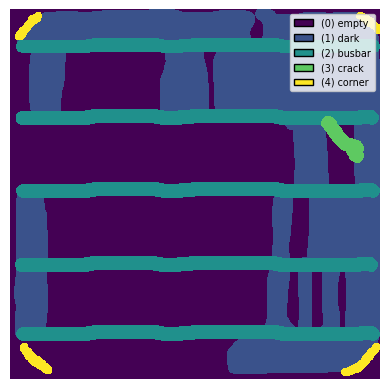

In [8]:
default_mask = stack_masks(category_dict)

plot_and_show_labels(default_mask)

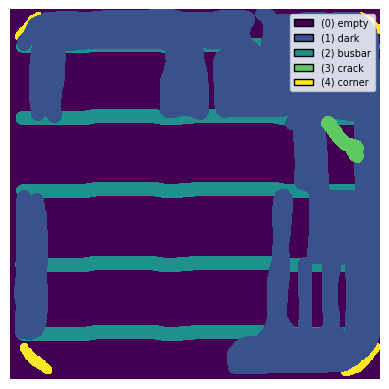

In [9]:
cracks_mask = stack_masks(category_dict, order=[2, 0, 1, 3])

plot_and_show_labels(cracks_mask)

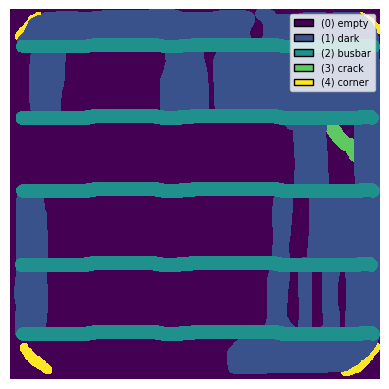

In [10]:
busbar_mask = stack_masks(category_dict, order=[1, 0, 2, 3])

plot_and_show_labels(busbar_mask)

In [11]:
i = 0
total = len(n_masks)
for n in n_masks:
    i += 1
    mask_path = os.path.join(mask_folder, f'{n}.jpg.json')
    img_path = os.path.join(img_folder, f'{n}.jpg')
    try:
        image = imread(img_path)
        category_dict = load_mask(mask_path, image)
        save_dir_busbars = os.path.join(root, 'ann_npy_split_busbars', 'original', f'{n}.npy')
        save_dir_cracks = os.path.join(root, 'ann_npy_split_cracks', 'original', f'{n}.npy')
        
        busbars_mask = stack_masks(category_dict, order=[1, 0, 2, 3])
        cracks_mask = stack_masks(category_dict, order=[2, 0, 1, 3])
        
        np.save(save_dir_busbars, busbars_mask)
        np.save(save_dir_cracks, cracks_mask)
        
        print(f"Saved ({i} / {total}): {n}")
    except Exception as e:
        print(n)
        print(e)
        continue

Saved (1 / 92): 1240 - NICE_SHJ_2_Isc (EL Image)
Saved (2 / 92): 1148 - Ea_SHJ_POE_3_Isc (EL Image)
Saved (3 / 92): -1_EL_18.09.2023-15-53-07_unknownID_ASU Minisample_SHJ8_117
Saved (4 / 92): 0_EL_18.09.2023-14-42-47_unknownID_ASU Minisample_04_48
Saved (5 / 92): 2_EL_18.09.2023-15-03-23_unknownID_ASU Minisample_08_71
Saved (6 / 92): 3_EL_18.09.2023-14-42-47_unknownID_ASU Minisample_03_48
Saved (7 / 92): 1227 - Old TC for PID_3_rear_Isc (EL Image)
Saved (8 / 92): 2_EL_18.09.2023-15-34-42_unknownID_ASU Minisample_SHJ3_97
Saved (9 / 92): 1_EL_18.09.2023-14-55-55_unknownID_ASU Minisample_06_62
Saved (10 / 92): 1_EL_18.09.2023-14-45-47_unknownID_ASU Minisample_09_51
Saved (11 / 92): 0_EL_18.09.2023-15-00-34_unknownID_ASU Minisample_07_68
Saved (12 / 92): 1152 - Ea_SHJ_POE_4_Isc (EL Image)
Saved (13 / 92): 1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103
Saved (14 / 92): 1145 - Ea_SHJ_POE_2_Isc (EL Image)
Saved (15 / 92): 2_EL_18.09.2023-14-51-50_unknownID_ASU Minisample_05_57
Sav